In [ ]:
%pip install qiskit pylatexenc

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator

import numpy as np

# Quantum State preparation

## $n = 2$

Let
\begin{equation}
| \Psi \rangle  = a | 00 \rangle + b | 10 \rangle + c | 01 \rangle + d | 11 \rangle,
\end{equation}
with $a, b, c, d > 0$.

Then
\begin{equation}
| \Psi \rangle = \cos \left( \theta_0 / 2 \right) \left( \cos \left( \theta_{10} / 2 \right) | 0 \rangle + \sin \left( \theta_{10} / 2 \right) | 1 \rangle \right) | 0 \rangle + \sin \left( \theta_0 / 2 \right) \left( \cos \left( \theta_{11} / 2 \right) | 0 \rangle + \sin \left( \theta_{11} / 2 \right) | 1 \rangle \right) | 1 \rangle,
\end{equation}
where
\begin{align}
    \theta_0        &= 2 \arccos \left( \sqrt{a^2 + b^2} \right), \\
    \theta_{01}     &= 2 \arccos \left( \tfrac{a}{\sqrt{a^2 + b^2}} \right), \\
    \theta_{11}     &= 2 \arccos \left( \tfrac{c}{\sqrt{c^2 + d^2}} \right). \\
\end{align}


Now let
\begin{equation}
| \Psi \rangle  = \tfrac{1}{\sqrt{30}} | 00 \rangle + \tfrac{2}{\sqrt{30}} | 10 \rangle + \tfrac{3}{\sqrt{30}} | 01 \rangle + \tfrac{4}{\sqrt{30}} | 11 \rangle.
\end{equation}

In [2]:
n = 2
psi = (1 + np.arange(2**n)) / np.linalg.norm(1 + np.arange(2**n))
psi

array([0.18257419, 0.36514837, 0.54772256, 0.73029674])

### angles
(in Qiskit's labelling the circuit will be "upside-down" compared to the circuit in class)

In [3]:
theta_0 = 2 * np.arccos(np.sqrt(np.sum(np.square(psi[:2]))))
theta_10 = 2 * np.arccos(psi[0] / np.sqrt(np.sum(np.square(psi[:2]))))
theta_11 = 2 * np.arccos(psi[2] / np.sqrt(np.sum(np.square(psi[2:]))))

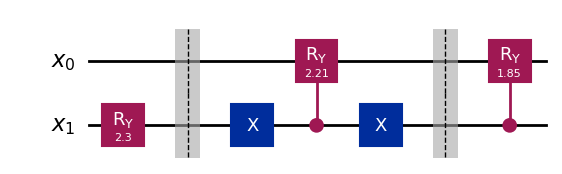

In [4]:
quantum_register = QuantumRegister(size=2, name="x")

qsp_circ = QuantumCircuit(quantum_register, name="Quantum State Preparation")

qsp_circ.ry(theta_0, quantum_register[1])

qsp_circ.barrier()

qsp_circ.x(quantum_register[1])
qsp_circ.cry(theta_10, quantum_register[1], quantum_register[0])
qsp_circ.x(quantum_register[1])

qsp_circ.barrier()

qsp_circ.cry(theta_11, quantum_register[1], quantum_register[0])

qsp_circ.draw(output="mpl")

In [5]:
np.linalg.norm(Statevector(qsp_circ).data - psi)

np.float64(1.2719202621569003e-16)

# $n = 3$

In [6]:
n = 3
psi = (1 + np.arange(2**n)) / np.linalg.norm(1 + np.arange(2**n))
psi, np.linalg.norm(psi)

(array([0.070014  , 0.14002801, 0.21004201, 0.28005602, 0.35007002,
        0.42008403, 0.49009803, 0.56011203]),
 np.float64(0.9999999999999999))

### angles

In [7]:
theta_0 = 2 * np.arccos(np.sqrt(np.sum(np.square(psi[:4]))))

theta_10 = 2 * np.arccos(np.sqrt(np.sum(np.square(psi[:2]))) / np.sqrt(np.sum(np.square(psi[:4]))))
theta_11 = 2 * np.arccos(np.sqrt(np.sum(np.square(psi[4:6]))) / np.sqrt(np.sum(np.square(psi[4:]))))

theta_200 = 2 * np.arccos(psi[0] / np.sqrt(np.sum(np.square(psi[:2]))))
theta_210 = 2 * np.arccos(psi[2] / np.sqrt(np.sum(np.square(psi[2:4]))))
theta_201 = 2 * np.arccos(psi[4] / np.sqrt(np.sum(np.square(psi[4:6]))))
theta_211 = 2 * np.arccos(psi[6] / np.sqrt(np.sum(np.square(psi[6:]))))

### we will need 2-controlled $Y$-rotations, which are not directly in qiskit. instead we will make one!

In [8]:
from qiskit.circuit.library.standard_gates import RYGate

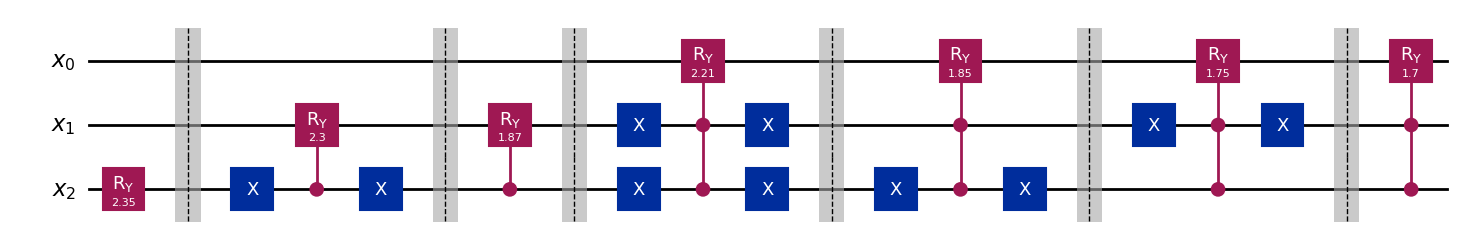

In [9]:
quantum_register = QuantumRegister(size=3, name="x")

qsp_circ = QuantumCircuit(quantum_register, name="Quantum State Preparation")

qsp_circ.ry(theta_0, quantum_register[2])

qsp_circ.barrier()

qsp_circ.x(quantum_register[2])
qsp_circ.cry(theta_10, quantum_register[2], quantum_register[1])
qsp_circ.x(quantum_register[2])

qsp_circ.barrier()

qsp_circ.cry(theta_11, quantum_register[2], quantum_register[1])

qsp_circ.barrier()

qsp_circ.x(quantum_register[1:])
qsp_circ.append(RYGate(theta_200).control(2), quantum_register[::-1])
qsp_circ.x(quantum_register[1:])

qsp_circ.barrier()

qsp_circ.x(quantum_register[2])
qsp_circ.append(RYGate(theta_210).control(2), quantum_register[::-1])
qsp_circ.x(quantum_register[2])

qsp_circ.barrier()

qsp_circ.x(quantum_register[1])
qsp_circ.append(RYGate(theta_201).control(2), quantum_register[::-1])
qsp_circ.x(quantum_register[1])

qsp_circ.barrier()

qsp_circ.append(RYGate(theta_211).control(2), quantum_register[::-1])


qsp_circ.draw(output="mpl")

In [10]:
np.linalg.norm(Statevector(qsp_circ).data - psi)

np.float64(2.5888677460363984e-16)

# Quantum Simulation

## implementing $\exp \left( i \tfrac{\tau}{2} Z^{\otimes k} \right)$:

Note: $Z^{\otimes k} |x>_k = (- 1)^{h(x)} |x>_k$, where $h(x) = \sum_{a = 0}^{k - 1} x_a$ is the <i>Hamming wieght</i> of $x \in \mathbb{F}_2^k$. Hence, $\exp \left( i \tfrac{\tau}{2} Z^{\otimes k} \right) |x>_k = \exp \left( i \tfrac{\tau}{2} (- 1)^{h(x)} \right) |x>_k$.

Furthermore, $h(x)$ is only relevant modulo 2 in the formula.

Thus, if we can "compute" $h(x) \mod 2$ on the one of the qubits, then an $R_Z (\tau)$ gate on the qubit will create the correct phase and we just need to "uncompute" the Hammiing weight.

the following circuit implements $|y>_{k - 1} |z>_1 \mapsto |y>_{k - 1} |h(y, z)>_1$

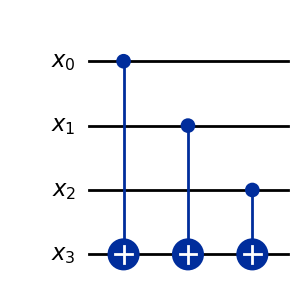

In [11]:
k = 4

quantum_register = QuantumRegister(size=k, name="x")

circ = QuantumCircuit(quantum_register, name="Hamming weight computer")

for q in quantum_register[:-1]:
    circ.cx(q, quantum_register[- 1])

circ.draw(output="mpl")

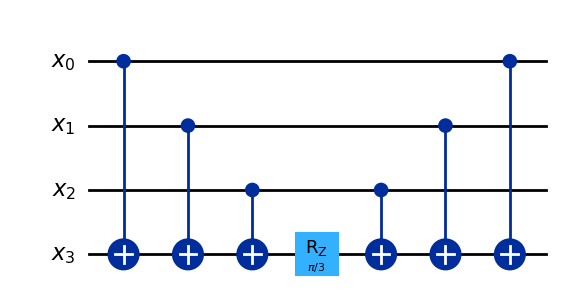

In [12]:
k = 4
tau = np.pi / 3

quantum_register = QuantumRegister(size=k, name="x")

circ = QuantumCircuit(quantum_register)

for q in quantum_register[:-1]:
    circ.cx(q, quantum_register[- 1])

circ.rz(tau, quantum_register[-1])

for q in quantum_register[:-1][::-1]:
    circ.cx(q, quantum_register[- 1])

circ.draw(output="mpl")

In [13]:
O = Operator(circ).data

O

array([[0.8660254-0.5j, 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ],
       [0.       +0.j , 0.8660254+0.5j, 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ],
       [0.       +0.j , 0.       +0.j , 0.8660254+0.5j, 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ],
       [0.       +0.j , 0.       +0.j , 0.       +0.j , 0.8660254-0.5j,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.   

## verfiy

In [18]:
Z = np.diag([1, - 1])
for _ in range(k - 1):
    Z = np.kron(Z, np.diag([1, - 1]))

Z

array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

### $Z$ is diagonal, so the matrix exponential is easy to compute

In [23]:
O_correct = np.diag(np.exp(- 1j * tau * np.diag(Z) / 2))

O_correct

array([[0.8660254-0.5j, 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ],
       [0.       +0.j , 0.8660254+0.5j, 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ],
       [0.       +0.j , 0.       +0.j , 0.8660254+0.5j, 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.       +0.j ],
       [0.       +0.j , 0.       +0.j , 0.       +0.j , 0.8660254-0.5j,
        0.       +0.j , 0.       +0.j , 0.       +0.j , 0.   

In [24]:
np.linalg.norm(O - O_correct)

np.float64(0.0)